<a href="https://colab.research.google.com/github/Kamaukaguru/NLP-twitter-analysis/blob/EDA/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP TWITTER ANALYSIS

* Final Project Submission
* Group Members
   1. Benson Kamau
   2. Kevin Muchori
   3. Nancy Chelangat
   4. Sally Kinyanjui
   5. Breden Mugambi

* Student Pace: Full-Time
* Instructor's: Nikita Njoroge

### Problem Statement
Accurately classifying the sentiments expressed in tweets about topics or brands into specific classes- positive, negative or neutral is a huge challenge for companies like Apple and Google. Given the diverse nature of informal data, with its use of slang, abbreviations, coming up with a reliable sentiment analysis model that can effectively interpret and classify the tweets can be a complex task. Getting this task right provides a wide variety of novel information for a company like Apple by providing insights and creating better understanding overall of how consumers interact with products/brands.

### Objective
The main objective is to build a model that can rate the sentiment of  a tweet based on its content.

#### Project Success Metrics
Over 75% accuracy on the testing data.

#### Importing relavent Libraries

In [115]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import regexp_tokenize, word_tokenize,TweetTokenizer, RegexpTokenizer





In [116]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/jarma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jarma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jarma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Data Loading and Understanding

The dataset that will be used in this study comes from CrowdFlower via data.world through this link - https://data.world/crowdflower/brands-and-product-emotions.


In [117]:
#create a function that loads data and gets the info about the data.
def load_and_get_info(file_path, encoding='utf-8'):
    try :
        # Load data
        df = pd.read_csv(file_path, encoding=encoding)

        # Display the first few rows of the DataFrame
        df_head = df.head()

        # Get information about the DataFrame
        df_info = df.info()

        return df,df_info, df_head
    except UnicodeDecodeError:
        print(f"Failed to decode {file_path} with encoding {encoding}. Trying with 'latin1' encoding.")
        return load_and_get_info(file_path, encoding='latin1')

# A function that checks the data types of DataFrame columns and return the count of columns for each data type category.
def check_data_types(df):

    data_type_counts = df.dtypes.replace({'object': 'string'}).value_counts().to_dict()
    return data_type_counts

In [118]:
file_path1 = 'tweet-analysis.csv'
df1,data_info, data_head = load_and_get_info(file_path1)
print(data_info)
print("\nFirst few rows of the DataFrame:")
data_head #data_head

Failed to decode tweet-analysis.csv with encoding utf-8. Trying with 'latin1' encoding.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None

First few rows of the DataFrame:


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset contains the following columns:

1. 'tweet_text' column
    - Contains the text of the tweet.
2. 'emotion_in_tweet_is_directed_at' column
    - Contains the person or entity that the tweet is directed at.
3. 'is_there_an_emotion_directed_at_a_brand_or_product' column
    - Indicates the kind of emotion in the tweet directed at the brand or product

The dataset has a total of 9093 data points.



In [119]:
#check the data types of DataFrame columns in our training set values.
data_type_counts = check_data_types(df1)
print("Count of columns for each data type category:")
print(data_type_counts)

Count of columns for each data type category:
{'string': 3}


The dataset has one data type category .i., object type.


To simplify working with the dataset, we will rename the columns to simpler and shorter names.


In [120]:
# function to rename the column names
def rename_columns(df, columns_dict):
    """
   Parameters:
    df (pd.DataFrame): The DataFrame whose columns need to be renamed.
    columns_dict (dict): A dictionary where keys are current column names and values are the new column names.
    """
    df.rename(columns=columns_dict, inplace=True)
    return df

# Define the dictionary for renaming columns
columns_dict = {
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'target_entity',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}

# Rename columns using the dictionary
df1 = rename_columns(df1, columns_dict)

print("\nRenamed DataFrame columns:")
print(df1.columns)
df1.head()


Renamed DataFrame columns:
Index(['tweet', 'target_entity', 'emotion'], dtype='object')


,tweet,target_entity,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset has been successfully renamed and the column names are now more descriptive.

# Data Cleaning
This is an essential aspect so as to ensure that the text data is consistent and free of errors. For this project, we will check for missing values, checking for duplicates,
remove white spaces, handle capitalization.



In [121]:
# Check missing values
df1.isna().sum()

tweet               1
target_entity    5802
emotion             0
dtype: int64

There is only one missing tweet text value, which will be removed. There are 5,802 missing "target_entity" values; however, this is acceptable since the current project focuses on overall tweet sentiment rather than specific items. These missing values will be replaced with an "Uncategorized" classification.

In [122]:
#Removing Null Tweets, Removing Duplicate entries and Filling in missing Item Values

#Removing 1 null 'Tweet' Entry
df1.dropna(subset = ['tweet'], inplace=True)

#Removing Duplicates
df1.drop_duplicates(inplace=True)

#Filling in Null "Item" categories with "Uncategorized"
df1['target_entity'].fillna('Uncategorized', inplace=True)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9070 non-null   object
 1   target_entity  9070 non-null   object
 2   emotion        9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


At this point there should not be any duplicate entries or null values in the data and the total row count in the dataset has decreased from 9092 to 9070.

Text Cleaning: The function below cleans the tweet column by removing white spaces, converting to lower case, and removing special characters.

In [123]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = text.lower()
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    text = pattern.sub('', text)
    return text

# Apply the clean_text function to the tweet column
df1['cleaned_tweet'] = df1['tweet'].apply(clean_text)
df1.head()

,tweet,target_entity,emotion,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...


The additional column cleaned_tweet stores the text after text cleaning.

## Lemmatization ,stop word removal and tokenization

In [124]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# function to lemmatize text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatize_text function to the 'cleaned_tweet' column
df1['lemmatized_tweet'] = df1['cleaned_tweet'].apply(lemmatize_text)

df1.head(10)




,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 i have a 3g iphone after 3 hr tweetin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...,jessedee know about fludapp awesome ipadiphone...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,sxsw i hope this year festival isnt a crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff on fri sxsw marissa maye...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Uncategorized,No emotion toward brand or product,teachntech00 new ipad apps for speechtherapy a...,teachntech00 new ipad apps for speechtherapy a...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,sxsw is just starting ctia is around the corne...,sxsw is just starting ctia is around the corne...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart and simple idea rt madebyman...,beautifully smart and simple idea rt madebyman...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting down the days to sxsw plus strong can...,counting down the day to sxsw plus strong cana...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited to meet the samsungmobileus at sxsw so...,excited to meet the samsungmobileus at sxsw so...


WordNetLemmatizer() is used to reduce words to their base or root form. This is what is known as lemmatization.

This function def lemmatize_text(text)  tokenizes the input text into words,lemmatizes each word and joins the lemmatized words back into a string.

From the output , the original tweet is the raw tweet text,the cleaned  tweet is the twwet after preprocessing  and the lemmatized tweet is the cleaned twwet after lemmatization.

In [125]:
# Load the stop words
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In the input, english indicates that the output required is supposed to be a setg of English stop words.

This set of stop words can be used in text preprocessing tasks

In [126]:
def preprocess_text_nltk(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    r_stop_words = [word for word in tokens if word.lower() not in stop_words]


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# function to lemmatize text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatize_text function to the 'cleaned_tweet' column
df1['lemmatized_tweet'] = df1['cleaned_tweet'].apply(lemmatize_text)
df1.head(10)

,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 i have a 3g iphone after 3 hr tweetin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...,jessedee know about fludapp awesome ipadiphone...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,sxsw i hope this year festival isnt a crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff on fri sxsw marissa maye...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Uncategorized,No emotion toward brand or product,teachntech00 new ipad apps for speechtherapy a...,teachntech00 new ipad apps for speechtherapy a...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,sxsw is just starting ctia is around the corne...,sxsw is just starting ctia is around the corne...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart and simple idea rt madebyman...,beautifully smart and simple idea rt madebyman...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting down the days to sxsw plus strong can...,counting down the day to sxsw plus strong cana...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited to meet the samsungmobileus at sxsw so...,excited to meet the samsungmobileus at sxsw so...


Similar to lemmatization,both functions play the same role .

The function 'def preprocess_text_nltk(text)' is used to tokenize the text.

In [127]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
   # for
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english')
              and token not in punctuation]
    return tokens


Pattern r"\b\w+(?:'\w+)?\b"  used for tokenizing text while keeping words with apostrophes. Below is an example.

In [128]:
import re
from nltk.tokenize import RegexpTokenizer

# Define the pattern
pattern = r"\b\w+(?:'\w+)?\b"

# Create a RegexpTokenizer with the pattern
tokenizer = RegexpTokenizer(pattern)

# Example tweet
tweet = "I'm excited about the iPhone's new features! Isn't it amazing?"

# Tokenize the tweet
tokens = tokenizer.tokenize(tweet)

# Print the tokens
print(tokens)


["I'm", 'excited', 'about', 'the', "iPhone's", 'new', 'features', "Isn't", 'it', 'amazing']


This output shows that the tokenizer breaks dwon the tweet into components,and handling even  shortened words and ownership accurately.

In [129]:
df1.sample(10)

,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
7515,#Google &quot;product gatekeeper&quot; Marissa...,Uncategorized,No emotion toward brand or product,google quotproduct gatekeeperquot marissa maye...,google quotproduct gatekeeperquot marissa maye...
4335,"joining @mention soon: 12:30pm, Hilton 615AB, ...",Uncategorized,No emotion toward brand or product,joining mention soon 1230pm hilton 615ab at sx...,joining mention soon 1230pm hilton 615ab at sx...
4627,I was going to mock the tech-nerds for coming ...,iPad,Negative emotion,i was going to mock the technerds for coming t...,i wa going to mock the technerds for coming to...
8738,Hanging out with @mention connecting @mention ...,Uncategorized,No emotion toward brand or product,hanging out with mention connecting mention in...,hanging out with mention connecting mention in...
117,"At #SXSW, #Apple schools the marketing experts...",Uncategorized,No emotion toward brand or product,at sxsw apple schools the marketing experts link,at sxsw apple school the marketing expert link
1547,@mention @mention @mention Can hear them worki...,Uncategorized,No emotion toward brand or product,mention mention mention can hear them workin h...,mention mention mention can hear them workin h...
6633,RT @mention RT: It's not a rumor: Apple is ope...,Apple,Positive emotion,rt mention rt its not a rumor apple is opening...,rt mention rt it not a rumor apple is opening ...
1903,@mention After #SXSW I will never again take a...,Uncategorized,Positive emotion,mention after sxsw i will never again take a f...,mention after sxsw i will never again take a f...
2109,&quot;ideas not objects&quot; Robert burner hi...,Uncategorized,No emotion toward brand or product,quotideas not objectsquot robert burner hired ...,quotideas not objectsquot robert burner hired ...
8706,#SXSW Future 15 Program: Google TV to iPad Ap...,Uncategorized,No emotion toward brand or product,sxsw future 15 program google tv to ipad apps...,sxsw future 15 program google tv to ipad apps ...


Compared to other outputs this one right here differs from the rest becuase here we used sample and the samples of the rows we printed might containtweets with varying characteristicss.

In [130]:
df1['target_entity'].fillna('Uncategorized', inplace=True)


# **Exploratory Data Analysis**

This involves understanding the characteristics of the text data, identifying patterns, and uncovering potential challenges. By performing EDA, we gain valuable insights into the dataset, inform feature engineering decisions, and build more effective NLP models. This exploratory phase helps to prevent potential pitfalls and ensures that subsequent modeling efforts are grounded in a solid understanding of the data.

We can begin with finding the number of words in the document. In our case, it would be the "Tweet" column. To do this, we can write a function to find out, then find the description of the word count, such as mean, mode. and such

In [131]:
def count_words(text):
  """Counts the number of words in a given text."""
  words = text.split()
  return len(words)

In [132]:
df1['word_count'] = df1['tweet'].apply(count_words)
df1['word_count'].describe()


count    9070.000000
mean       17.765932
std         4.962136
min         2.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        33.000000
Name: word_count, dtype: float64

As seen, we have a count of 9070, and with the percentile ranges between 13 and 33. We also get to see the mean and other statistics using the describe() method. We can easily visualize it with a histogram that focuses on grouped distrubution to avoid visual clatter

---



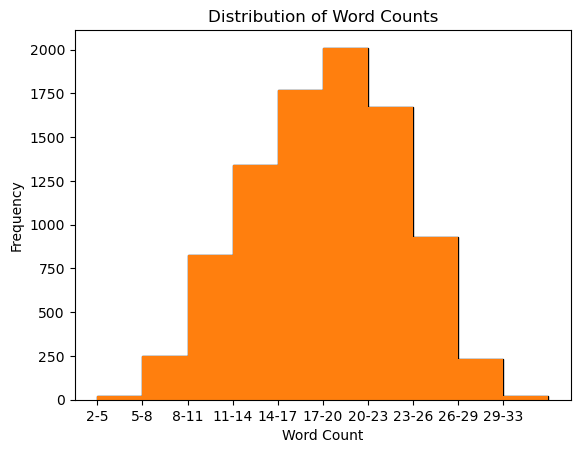

In [133]:
# Histogram
plt.hist(df1['word_count'], bins=10, edgecolor='black')

# Calculate bin edges
counts, bins, patches = plt.hist(df1['word_count'], bins=10)

# Create bin labels
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# Set x-axis labels
plt.xticks(bins[:-1], bin_labels)

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

Visually, our data tells us that most of the words in the document lie between 20-23 words. But we need to find out the statistics of usage of each of the words in the document. For this, we can count each word in the "Tweet" column. This s easily accomplished by tokenizing the words in the "Tweet" column, and going through all the words in the column, the calculating word frequencies and visually displaying it

In [134]:
from collections import Counter

df1['tokenized_tweets'] = df1['tweet'].apply(process_tweet)

all_words = [word for sublist in df1['tokenized_tweets'] for word in sublist]

# Calculate word frequencies
word_counts = Counter(all_words)

# Convert word counts to a DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

word_freq_df.describe()

,count
count,9831.000000
mean,11.760859
std,144.766248
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,9593.000000


<Figure size 1200x600 with 0 Axes>

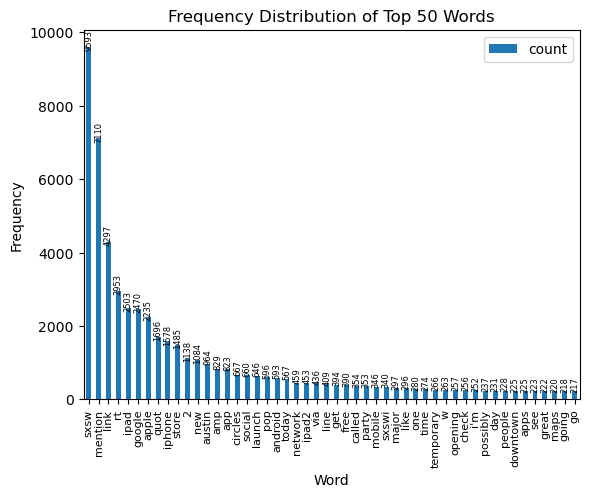

In [135]:

# Visualize the top 20 words
plt.figure(figsize=(12, 6))
ax = word_freq_df[:50].plot(x='word', y='count', kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=6,  # Adjust font size here
                rotation=90)  # Adjust rotation here

#word_freq_df[:40].plot(x='word', y='count', kind='bar')
plt.title('Frequency Distribution of Top 50 Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(
    rotation = 90,
    fontsize = 8)
plt.show()

As seen, the 1st 5 words pertain to X( formerly known as Twitter)'s abstract functions, or either the event name. We know this due to domain knowledge ot both X and SXSW. With this, in our visualization, we can remove the 1st 5 so that we can begin

<Figure size 1200x600 with 0 Axes>

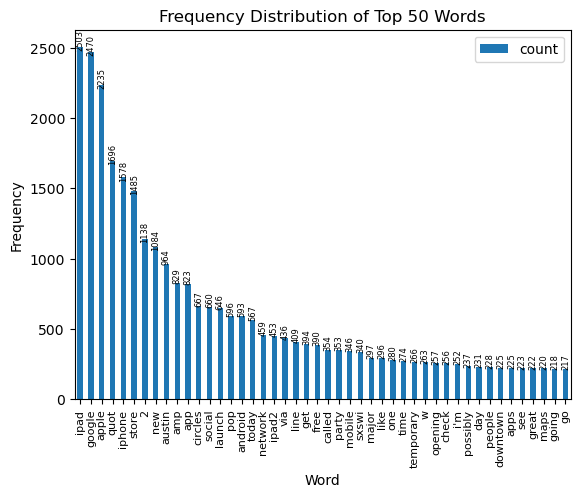

In [136]:

# Visualize the top 20 words
plt.figure(figsize=(12, 6))
ax = word_freq_df[4:50].plot(x='word', y='count', kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=6,  # Adjust font size here
                rotation=90)  # Adjust rotation here

#word_freq_df[:40].plot(x='word', y='count', kind='bar')
plt.title('Frequency Distribution of Top 50 Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(
    rotation = 90,
    fontsize = 8)
plt.show()

Much Better. We can now see that the word 'ipad' frequently appears with 2503 appearances. For those who may need a better visualization medium, we can use a wordcloud

A word cloud is a visual representation of text data where words are sized proportionally to their frequency of occurrence in a given document or corpus. It provides a rapid overview of the most prominent terms, allowing for quick identification of key topics and themes. Word clouds are particularly effective when dealing with large volumes of text data, as they can condense information into a visually appealing format.

We can use the lemmatized_tweet column to generate a wordcloud

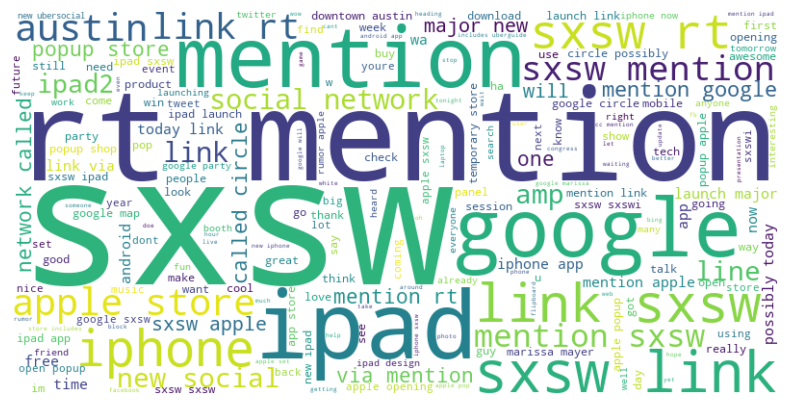

In [137]:
from wordcloud import WordCloud

text = ' '.join(df1['lemmatized_tweet'].astype(str))
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can also use a bit of sentiment analysis to determine the positivity, negativity or neutrality of a tweet. We can use a library called TextBlob, as it returns a numerical value, ranging from -1 to 1, where negative 1 indicates negativity, whule 1 indicates positivity. O indicates neutrality

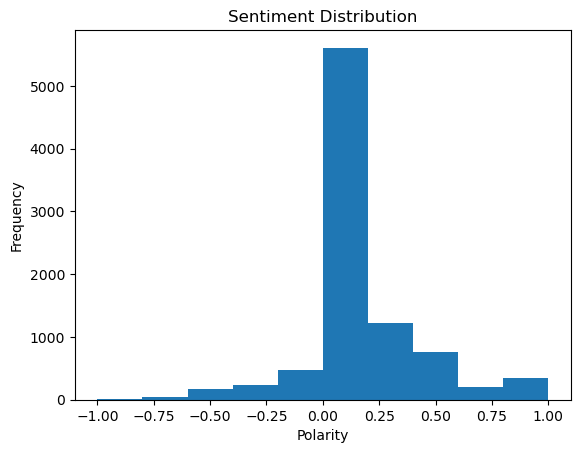

In [138]:
from textblob import TextBlob

df1['polarity'] = df1['lemmatized_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.hist(df1['polarity'], bins=10)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

As seen, most of the words lie near the zero mark. But we can go even further. We can use tokens and their tags to find out where most of the words lie in the parts of speech. This is known as parts-of-speech tagging(POS tagging)
These tags indicate the syntactic role of a word, such as whether it's a noun, verb, adjective, adverb, and so on.

How POS Tagging Works
* Tokenization: The text is broken down into individual words or tokens.
* Tagging: Each token is assigned a POS tag based on its context and the rules of the language.

Common POS Tags

* Nouns (NN): person, place, thing, idea
* Verbs (VB): action words
* Adjectives (JJ): describe adjectives
* Adverbs (RB): describe averbs
* Adjectives, or other adverbs
* Prepositions (IN): show relationships between words
* Determiners (DT): articles (the, a, an), possessives (my, your)
* Conjunctions (CC): and, but, or

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jarma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


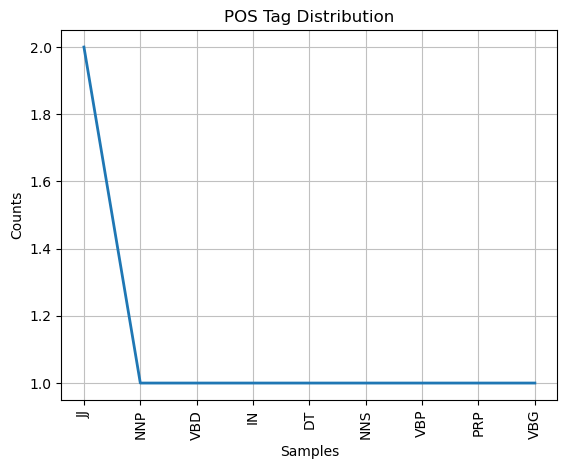

<Axes: title={'center': 'POS Tag Distribution'}, xlabel='Samples', ylabel='Counts'>

In [139]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

df1['tokenized_tweets'] = df1['tweet'].apply(process_tweet)

df1['tokenized_tweets'] = df1['tokenized_tweets'].apply(' '.join)
tagged = pos_tag(tokens)

# Extract POS tags
pos_tags = [tag[1] for tag in tagged]

# Count POS tag frequencies
fdist = nltk.FreqDist(pos_tags)

# Plot POS tag distribution
#plt.figure(figsize=(10, 5))
plt.title('POS Tag Distribution')
fdist.plot()
#plt.title('POS Tag Distribution')
#plt.show()

  in the target entities column, we focus on what services the tweets refer to. We can use the describe() function to find out on the info of the column

In [140]:
df1['target_entity'].describe()

count              9070
unique               10
top       Uncategorized
freq               5788
Name: target_entity, dtype: object

<Axes: title={'center': 'Target Entity Distribution'}, xlabel='target_entity', ylabel='count'>

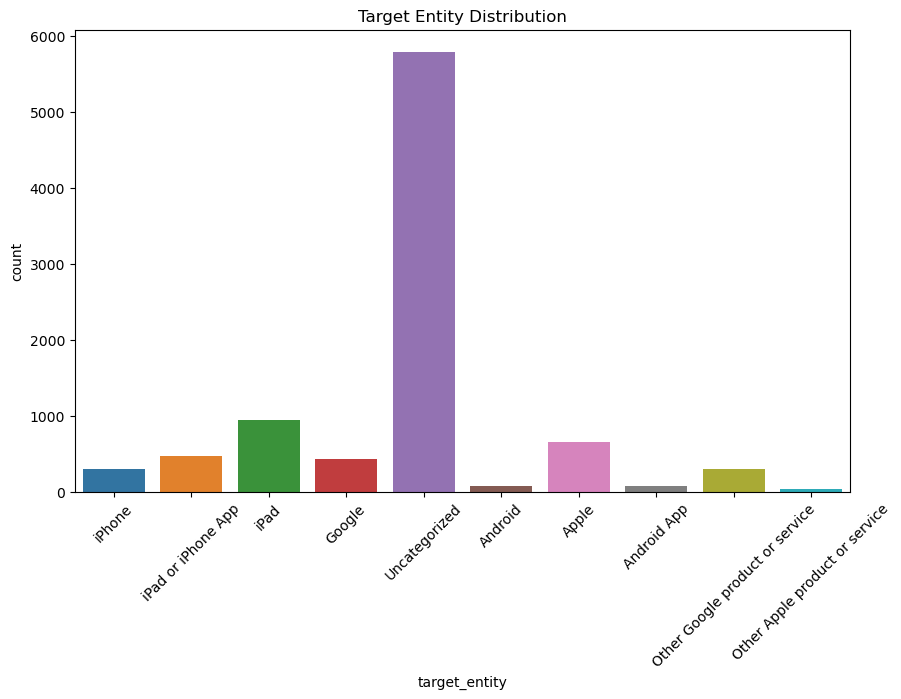

In [141]:
plt.figure(figsize=(10, 6))
plt.title('Target Entity Distribution')
plt.xticks(rotation = 45)
plt.xlabel('Target Entity')
plt.ylabel('Frequency')
sns.countplot(x='target_entity', data=df1)

With the uncategorized, we remember that that was what we placed on all empty entries in the column. But apart from it, ipad, Apple and Google are the most frequent entered target entries. We then check on the emotion column to see the reception of the target entities based on the tweets

In [142]:
df1['emotion'].value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

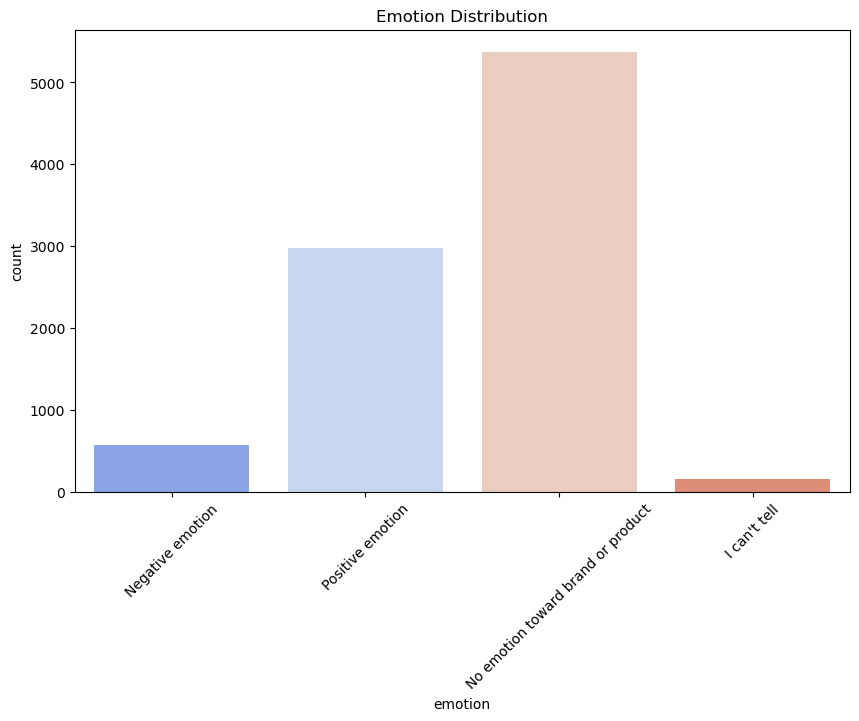

In [143]:
plt.figure(figsize=(10, 6))
plt.title('Emotion Distribution')
plt.xticks(rotation = 45)
plt.xlabel('Target Entity')
plt.ylabel('Frequency')
sns.countplot(x='emotion', data=df1, palette = 'coolwarm')

plt.show()

As we can see, most of the feedback is that they have no emotion.

## MODELING

We will be using different types of models that is Naive Bayes,Logistic Regression, Decision Tree, and Deep Learning models to see how well they can predict the emotions in the tweets. To check how good they are, we will use the metric of accuracy to see how the model works.

Accuracy: This shows how often they get things right.

### Vectorization

converting text data (which is unstructured) into a numerical format that machine learning models will understand and process. 
It will involve transforming text into numerical vectors that capture the semantic and syntactic information of the text.

### Tfidf Vectorization (Term Frequency - Inverse Document Frequency)


Term Frequency-Inverse Document Frequency, is a technique that combines two metrics: TF (Term Frequency) and IDF (Inverse Document Frequency). It's particularly useful when working with multiple documents. TF-IDF helps us identify words that are unique and provide more meaningful insights within a document by giving higher importance to rare words and lowering the importance of common words found across all documents.

we will divide our dataset into two portions: training and testing. This helps us ensure that our models perform well on new, unseen data. We allocate 20% of the data for testing.

In [144]:
# import library
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#texts will be my X
#labels will be my y
# Extract relevant columns
#independent variabe
X = df1['lemmatized_tweet']
#target variable
y = df1['emotion']

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Next, we convert the text data into numbers using TF-IDF. We train the vectorizer on the training data and then apply it to both the training and testing data.

In [145]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer()
# Fit the vectorizer
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

### Baseline model
#### 1. Naive Bayes
We chose the model because it is  simple and efficient to use.

In [146]:
# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Fit the model
baseline_nb.fit(X_train_tf, y_train)

# Predict on the training set
y_train_pred = baseline_nb.predict(X_train_tf)

# Predict on the test set
y_test_pred = baseline_nb.predict(X_test_tf)

In [147]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics
#calcuate the metrics
f1_train = metrics.f1_score(y_train, y_train_pred, average='weighted')
f1_test = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('Train Accuracy score:', metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy score: ', metrics.accuracy_score(y_test,  y_test_pred))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Train Accuracy score: 0.7235391400220507
Test Accuracy score:  0.6659316427783903
Train F1 score:  0.6714203351490385
Test F1 score:  0.594787328120069


In [148]:
y_test_pred = baseline_nb.predict(X_test_tf)
from sklearn.metrics import recall_score
# confusion matrix and classification report
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('Accuracy score: ',accuracy_score(y_test, y_test_pred))

[[   0    0   28    5]
 [   0    2  101   16]
 [   0    0 1064   42]
 [   0    0  414  142]]
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        33
                  Negative emotion       1.00      0.02      0.03       119
No emotion toward brand or product       0.66      0.96      0.78      1106
                  Positive emotion       0.69      0.26      0.37       556

                          accuracy                           0.67      1814
                         macro avg       0.59      0.31      0.30      1814
                      weighted avg       0.68      0.67      0.59      1814

Accuracy score:  0.6659316427783903


In [149]:
def plot_confusion_matrix(y_test, y_pred, classes):
    """
    Plots a confusion matrix.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

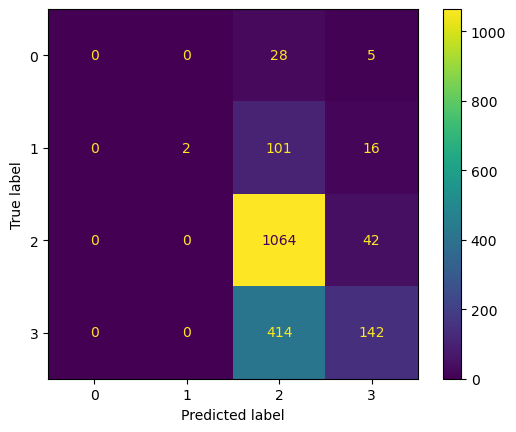

In [150]:
from sklearn.metrics import ConfusionMatrixDisplay

y_test_pred = baseline_nb.predict(X_test_tf)

#Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

#Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

#plot confusion matrix
disp.plot()
plt.grid(False)
plt.show()

#### Observations

#### 2.Logistic Regression

In [151]:
#import library
from sklearn.linear_model import LogisticRegression
# Create an instance of the LogisticRegression model
log_reg = LogisticRegression()
# Fit the model
log_reg.fit(X_train_tf, y_train)

# Predict on the training set
y_train_pred = log_reg.predict(X_train_tf)

# Predict on the test set
y_test_pred = log_reg.predict(X_test_tf)

In [152]:
#calcuate the metrics
f1_train = metrics.f1_score(y_train, y_train_pred, average='weighted')
f1_test = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('Train Accuracy score:', metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy score: ', metrics.accuracy_score(y_test,  y_test_pred))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Train Accuracy score: 0.8020948180815877
Test Accuracy score:  0.6824696802646086
Train F1 score:  0.7793789251871245
Test F1 score:  0.6535421096455041


In [156]:
y_test_pred = log_reg.predict(X_test_tf)
from sklearn.metrics import recall_score
# confusion matrix and classification report
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('Accuracy score: ',accuracy_score(y_test, y_test_pred))

[[  0   0  24   9]
 [  0  13  74  32]
 [  0   6 949 151]
 [  0   3 277 276]]
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        33
                  Negative emotion       0.59      0.11      0.18       119
No emotion toward brand or product       0.72      0.86      0.78      1106
                  Positive emotion       0.59      0.50      0.54       556

                          accuracy                           0.68      1814
                         macro avg       0.47      0.37      0.38      1814
                      weighted avg       0.66      0.68      0.65      1814

Accuracy score:  0.6824696802646086


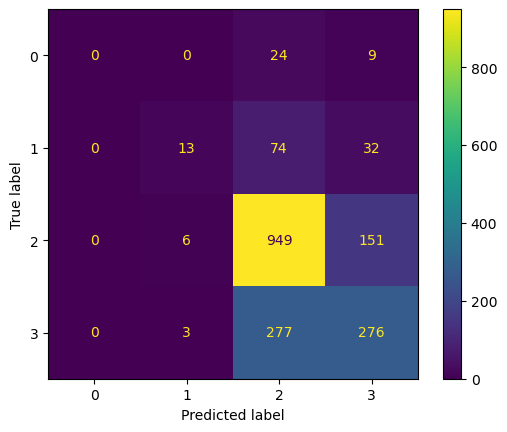

In [157]:
#Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

#Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

#plot confusion matrix
disp.plot()
plt.grid(False)
plt.show()

#### Observations

####  3.Decision Tree

In [154]:
# import library
from sklearn.tree import DecisionTreeClassifier
# Instatiate class
model_dt = DecisionTreeClassifier()
# Fit the model
model_dt.fit(X_train_tf, y_train)

# Predict on the training set
y_train_pred = model_dt.predict(X_train_tf)

# Predict on the test set
y_test_pred = model_dt.predict(X_test_tf)


In [155]:
#calcuate the metrics
f1_train = metrics.f1_score(y_train, y_train_pred, average='weighted')
f1_test = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('Train Accuracy score:', metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy score: ', metrics.accuracy_score(y_test,  y_test_pred))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Train Accuracy score: 0.9960033076074972
Test Accuracy score:  0.6052921719955898
Train F1 score:  0.9959999828804895
Test F1 score:  0.6057674746333329


In [158]:
y_test_pred = model_dt.predict(X_test_tf)
from sklearn.metrics import recall_score
# confusion matrix and classification report
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('Accuracy score: ',accuracy_score(y_test, y_test_pred))

[[  1   2  18  12]
 [  2  33  53  31]
 [ 12  45 767 282]
 [ 11  22 226 297]]
                                    precision    recall  f1-score   support

                      I can't tell       0.04      0.03      0.03        33
                  Negative emotion       0.32      0.28      0.30       119
No emotion toward brand or product       0.72      0.69      0.71      1106
                  Positive emotion       0.48      0.53      0.50       556

                          accuracy                           0.61      1814
                         macro avg       0.39      0.38      0.39      1814
                      weighted avg       0.61      0.61      0.61      1814

Accuracy score:  0.6052921719955898


#### Observations

#### 4.Support vector machine

In [160]:
#import library
from sklearn.svm import SVC
# Instantiate support vector classifier
svc = SVC()

# Fit the model
svc.fit(X_train_tf, y_train)

# Predict on the training set
y_train_pred = svc.predict(X_train_tf)

# Predict on the test set
y_test_pred = svc.predict(X_test_tf)

In [161]:
#calcuate the metrics
f1_train = metrics.f1_score(y_train, y_train_pred, average='weighted')
f1_test = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('Train Accuracy score:', metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy score: ', metrics.accuracy_score(y_test,  y_test_pred))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Train Accuracy score: 0.8907111356119074
Test Accuracy score:  0.7067254685777288
Train F1 score:  0.8801989399732401
Test F1 score:  0.6762832803508931


In [162]:
y_test_pred = svc.predict(X_test_tf)
from sklearn.metrics import recall_score
# confusion matrix and classification report
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('Accuracy score: ',accuracy_score(y_test, y_test_pred))

[[  0   0  25   8]
 [  0  20  75  24]
 [  0   2 992 112]
 [  0   1 285 270]]
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        33
                  Negative emotion       0.87      0.17      0.28       119
No emotion toward brand or product       0.72      0.90      0.80      1106
                  Positive emotion       0.65      0.49      0.56       556

                          accuracy                           0.71      1814
                         macro avg       0.56      0.39      0.41      1814
                      weighted avg       0.70      0.71      0.68      1814

Accuracy score:  0.7067254685777288


#### Observations

## DEEP LEARNING

## EVALUATION